# Описание проекта
Требуется разработать инструмент для **оценки вероятности возникновения ДТП** по заданному маршруту движения. Под риском подразумевается шанс возникновения ДТП с любым уровнем повреждений автотранспорта. После того как водитель заказал автомобиль, сел за руль и выбрал маршрут, система должна проанализировать уровень риска. В случае высокого уровня риска водитель получит предупреждение и рекомендации относительно маршрута. 

Идея создания подобной системы находится на этапе исследования и концептуализации. На данный момент отсутствует четкий алгоритм работы и аналогичные решения на рынке. Главная цель - выяснить возможность прогнозирования ДТП на основе исторических данных одного из регионов. 🚗🚦


## Установка библиотек, импорты

In [1]:
pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/107.7 kB ? eta -:--:--
   --------------- ------------------------ 41.0/107.7 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 107.7/107.7 kB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
pip install ydata-profiling

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn --upgrade

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 1.3 MB/s eta 0:00:09
   - -------------------------------------- 0.3/10.6 MB 4.2 MB/s eta 0:00:03
   -- ------------------------------------- 0.7/10.6 MB 6.9 MB/s eta 0:00:02
   ------ --------------------------------- 1.7/10.6 MB 11.0 MB/s eta 0:00:01
   --------- ------------------------------ 2.4/10.6 MB 12.9 MB/s eta 0:00:01
   ------------ --------------------------- 3.4/10.6 MB 13.4 MB/s eta 0:00:01
   --------------- ------------------------ 4.1/10.6 MB 13.7 MB/s eta 0:00:01
   ----------------- ---------------------- 4.6/10.6 MB 13.2 MB/s eta 0:00:01
   ------------------- -------------------- 5.1/10.6 MB 12.9 MB/s eta 0:00:01
   ------------------- -------------------- 5.2/10.6 MB 12.4 MB/s eta 0:00:01
   --------------------- ------------------ 5.7/10.6 MB 11.6 MB/s eta 0:00:

  You can safely remove it manually.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 
from ydata_profiling import ProfileReport
import numpy as np
import os
import datetime
from datetime import datetime, date, timedelta, time

import lightgbm as lgb
from catboost import CatBoostRegressor, Pool, cv
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

pd.options.display.max_columns = None
pd.options.display.float_format = '{: .2f}'.format

## Подключитесь к базе. Загрузите таблицы sql

In [6]:
db_config = {
'user': '***', # имя пользователя,
'pwd': '***', # пароль,
'host': '***',
'port': 0, # порт подключения,
'db': '***' # название базы данных,
} 
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string) 

def sql(query, con=engine):
    'выгружает данные в DataFrame'
    return pd.read_sql_query(query, con=con)

sample_df = sql('select 1 as check')
sample_df

,check
0,1


## Проведите первичное исследование таблиц

Изучаю структуру таблиц и наличие в них данных.  
Выгружу по 10 строк каждой таблицы, прсмотрю содержимое.

In [7]:
sql('select * from case_ids limit 10')

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


In [8]:
sql('select * from vehicles limit 10')

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


In [9]:
sql('select count(case_id), count(distinct case_id) from vehicles limit 10')

,count,count
0,1021234,792642


In [10]:
sql('select * from collisions limit 10')

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.00,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.00,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.00,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.00,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.00,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.00,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.00,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.00,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.00,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.00,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


In [11]:
sql('select * from parties order by case_id limit 10')

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,2,0081715,2,car,0,43.00,not applicable,not applicable,0.00
1,1,0081715,1,car,1,35.00,not applicable,not applicable,0.00
2,3,0726202,1,car,1,NaN,impairment unknown,G,NaN
3,5,3858022,2,car,0,58.00,had not been drinking,None,NaN
4,4,3858022,1,car,1,47.00,impairment unknown,G,NaN
5,6,3899441,1,car,1,16.00,impairment unknown,G,0.00
6,7,3899442,1,car,1,40.00,had not been drinking,None,0.00
7,8,3899442,2,car,0,46.00,had not been drinking,None,0.00
8,9,3899445,1,car,1,24.00,had not been drinking,None,0.00
9,10,3899445,2,car,0,32.00,had not been drinking,None,0.00


In [12]:
sql('''
select case_id, max(at_fault)
from parties p
group by 1 
having max(at_fault) = 0
''')

,case_id,max
0,4172388,0
1,4120901,0
2,4180663,0
3,4059861,0
4,4082697,0
...,...,...
111868,4894371,0
111869,5319099,0
111870,5441524,0
111871,5337833,0


Проверим, сколько case_id в каждой таблице

In [13]:
print('parties:', sql('select count(distinct case_id) from parties').values[0][0])
print('Vehicles:', sql('select count(distinct case_id) from Vehicles').values[0][0])
print('collisions:', sql('select count(distinct case_id) from collisions').values[0][0])

parties: 1400000
Vehicles: 792642
collisions: 1400000


parties и collisions содержат одинаковое кол-во case_id, а вот в Vehicles в ~2 раза меньше

**Вывод**  
- Информация в таблицах есть, все таблицы в наличии
- Ключ связи есть - это `case_id `

##  Проведите статистический анализ факторов ДТП

**Задача:**  
Выясните, в какие месяцы происходит наибольшее количество аварий. Проанализируйте весь период наблюдений

**Шаг 1.**  
Посмотрим, за какие периоды в принципе есть данные, нет ли пропусков

In [14]:
cases_ttl = sql('''
select date_trunc('month', collision_date)::date as mon,
    count(1) as cases_count
from collisions 
group by 1
''')

In [15]:
print('start month', cases_ttl.mon.min())
print('last month', cases_ttl.mon.max())
print('count months', cases_ttl.mon.count())

start month 2009-01-01
last month 2020-07-01
count months 56


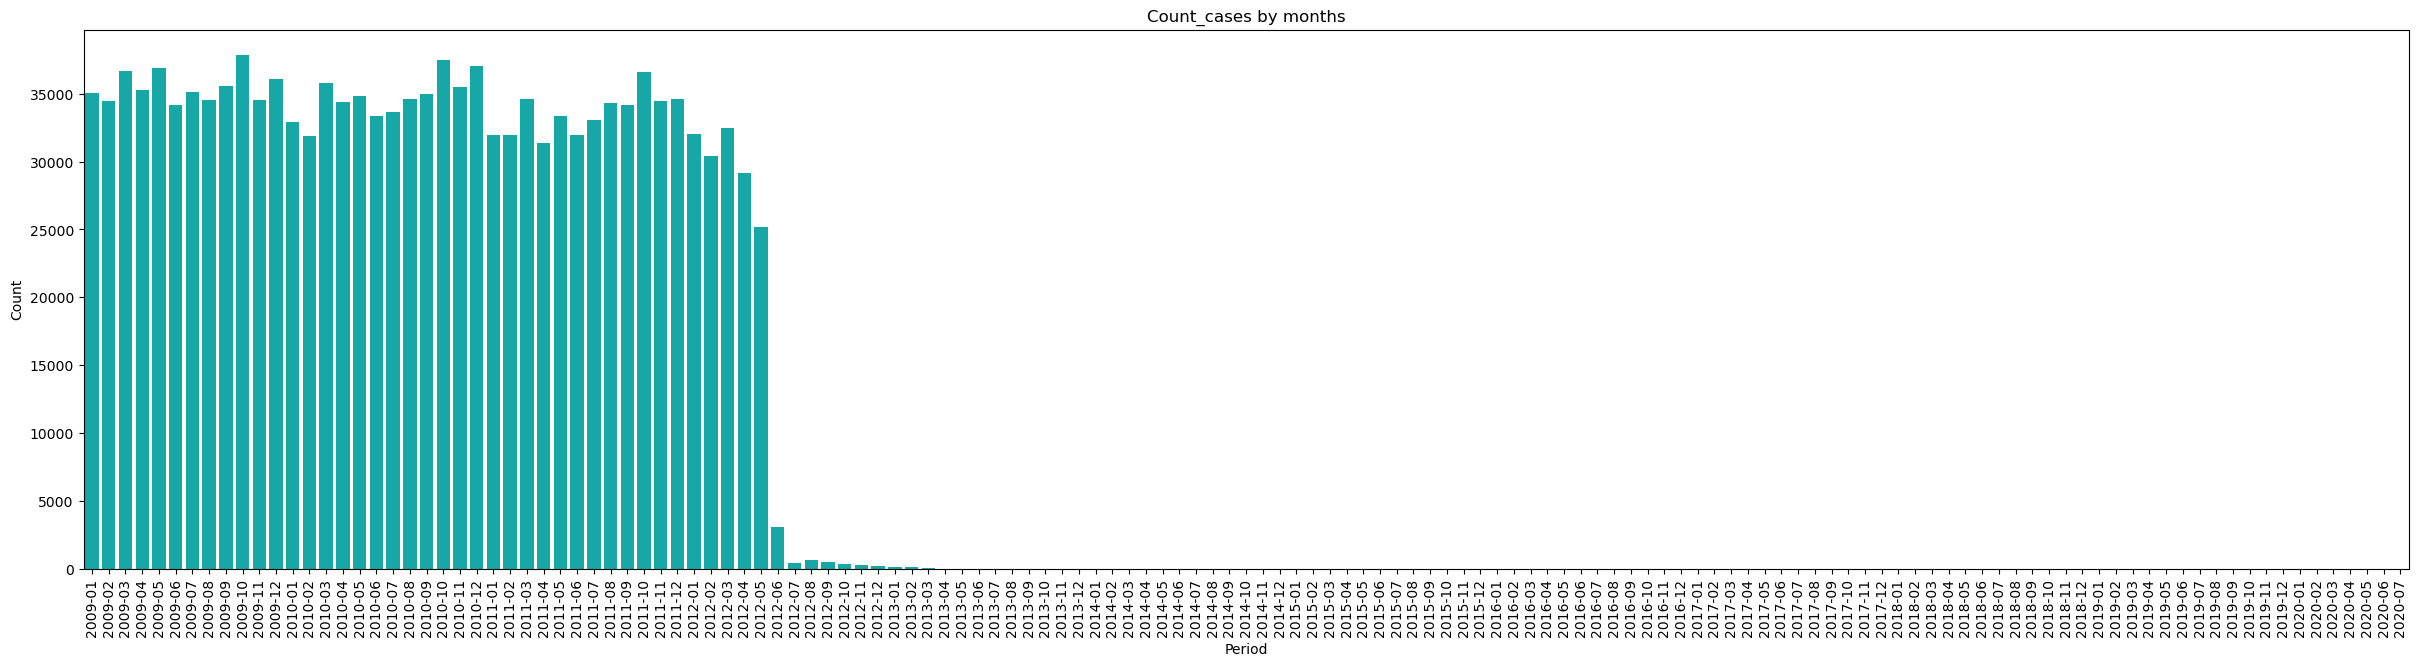

In [16]:
# создаем диапазон дат от начального до конечного месяца в данных из sql-запроса
all_months = pd.DataFrame(pd.date_range(start='2009-01-01', end='2020-07-01', freq='MS'), columns=['mon'])
# объединяем диапазон дат с данными из sql-запроса
cases_ttl['mon'] = pd.to_datetime(cases_ttl['mon'])
cases_ttl = cases_ttl.merge(all_months, how='right', on='mon')
# для нормального отображения на графике
cases_ttl['mon_str'] = cases_ttl['mon'].dt.strftime('%Y-%m')
# строим график наличия данных по месяцам
plt.figure(figsize=(30,7))
sns.barplot(x='mon_str', y='cases_count', data=cases_ttl, color = 'c')
plt.xticks(rotation=90)
plt.title('Count_cases by months')
plt.xlabel('Period')
plt.ylabel('Count')
plt.show()

Очевидно, что с +- апреля 2012 года кейсы из таблицы практически пропали, т.е. данные неполные. Для построения анализа эти года использовать некорректно.  
Поэтому я в sql-запросе отфильтрую данные на 2009-2011 года, т.к. только в них данные выглядят полными.

In [17]:
cases_mon = sql('''
select extract('month' from collision_date)::int as mon, count(1) as cases_count
from collisions 
where extract('year' from collision_date)::int between 2009 and 2011
group by 1
''')

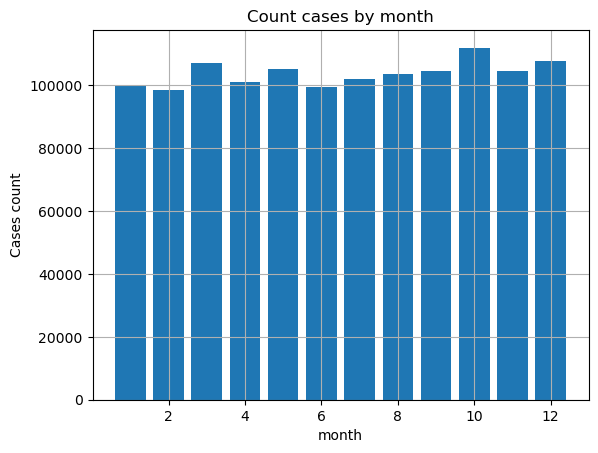

In [18]:
plt.bar('mon', 'cases_count', data=cases_mon)
plt.xlabel('month')
plt.ylabel('Cases count')
plt.title('Count cases by month')
plt.grid()
plt.show()

**Вывод:**   
Самая высокая аварийность находится в промежутке с октября по декабрь.  
Однако не факт, что это не случайность, т. к. логично было бы предположить, что аварии чаще случаются зимой, однако в данных видно, что в январе и феврале аварий меньше всего.

### Задачи коллегам для встречи [имитация рабочего процесса]

Иван Ложкин:
- Машины с каким типом кузова чаще попадают в аварии на перекрестках в облачную погоду? Вывести процентное соотношение

Евгения Галушко:
- Сколько в любой степени пьяных водителей водителей попадало в аварии, уснув за рулем, по месяцам?

Павел Барагозин:
- Оценить степень серьезности происшествия (COLLISION_DAMAGE) для аварий в дождь/снегопад/туман или при несухой дороге при столкновении с любым объектом, кроме автомобиля

Эльвира Губайдуллина:
- Доля по основным факторам аварий в % по месяцам (нормированная гистограмма)

Анатолий Ли:
- При каком освещении седаны чаще попадают в аварию при условии сухой дороги и ясной/облачной погоде?

Милана Жаныбекова:
- Оценить средний возраст автомобилей по населенным пунктам, у которых серьезность происшествия выше или равно "SEVERE DAMAGE". Брать только виновников аварии. Оставить только топ-30 населенных пунктов.

Так как Милана Жаныбекова и Иван Ложкин у нас стажеры, прикрепляю пояснение по порядку работы.  
**Милана:**
1. Средний возраст авто из таблицы Vehicles, столбец VEHICLE_AGE, функция avg().
2. Населенные пункты возьми из таблицы collisions, столбец COUNTY_LOCATION, там же серьезность вопреждений - COLLISION_DAMAGE.
3. Чтобы убрать дубли и взять только виновников аварии, джойни с таблицой parties по ключам case_id & party_number. В parties ставь условие at_fault = 1
4. Не забудь про группировку для получения агрегата!
5. Оставь только топ-30 пунктов по убыванию метрики с помощью order by и limit
6. С помощью функции `sql`, разработанной старшим аналитиком Барагозиным, выгрузи данные в dataframe и построй простой bar chart в библиотеке matplotlib. По оси Х - населенный пункт.  
7. Сделай вывод о том, что ты видишь на графике. 

**Иван:**  
1. Тип кузова: vehicles.vehicle_type
2. Перекресток: collisions.intersection, погода collisions.weather_1
3. Объединить по case_id
4. Сейчас на виновников или нет не делим осознанно, берем все
5. Данные выгрузить в dataframe
6. Построить круговую диаграмму с помощью `plt.pie`
7. Опиши результат словами 

### Выполнение задач

**Задание Миланы**

In [19]:
# выгрузка данных по условию задачи
mean_vehicle_age = sql('''
SELECT c.county_location,
       avg(vehicle_age) AS mean_vehicle_age
FROM vehicles v
JOIN collisions c ON c.case_id = v.case_id
JOIN parties p ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE p.at_fault = 1
  AND c.collision_damage <> 'scratch'
GROUP BY 1
ORDER BY mean_vehicle_age DESC
LIMIT 30
''')

In [20]:
mean_vehicle_age.head()

,county_location,mean_vehicle_age
0,sierra,6.68
1,alpine,6.00
2,inyo,5.89
3,amador,5.79
4,trinity,5.76


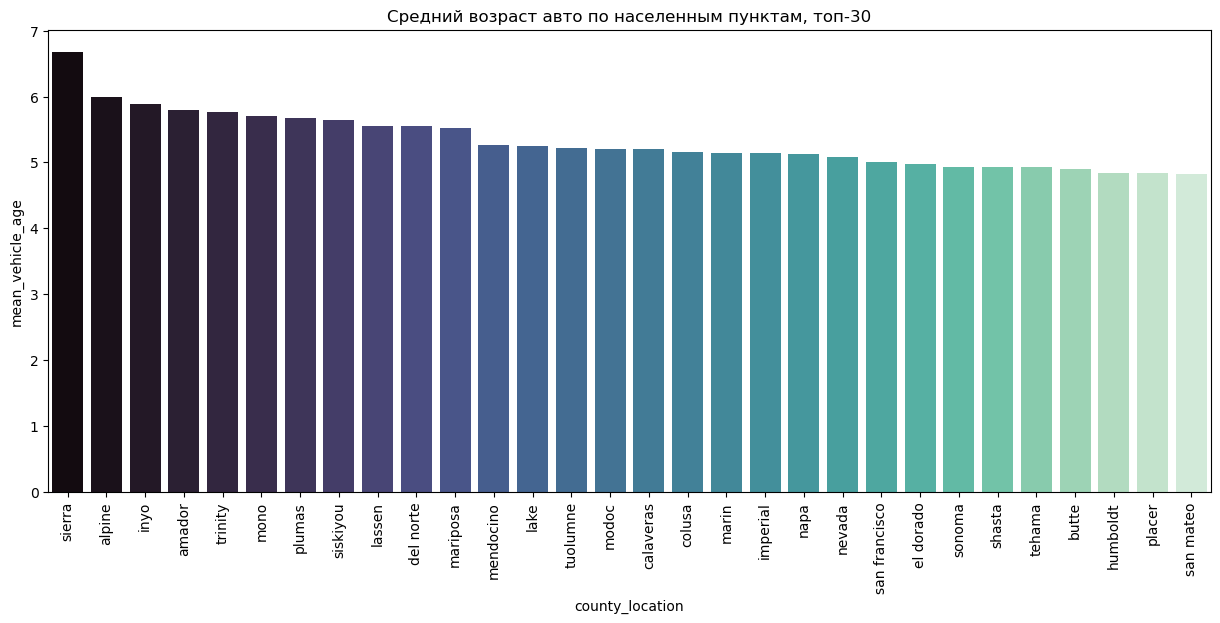

In [21]:
# построение графика
plt.figure(figsize=(15,6))
sns.barplot(x='county_location', y='mean_vehicle_age', data=mean_vehicle_age, palette="mako")
plt.xticks(rotation=90)
plt.title('Средний возраст авто по населенным пунктам, топ-30')
plt.show()

**Вывод:**  
Населенный пункт с самыми "старыми" автомобилями, при этом, попадавшими в аварию - это **sierra**. Также стоит обратить внимание на **alpine, inyo и amador**.  

Коллегам из бизнеса стоит инициировать проверку, не случайность ли это (может быть, там умышленно стоит старый каршеринг? если да, то оправдано ли это? соотносится ли с уровнем доходов района? оправдано ли это?).  
Данные вопросы выходят за рамки текущего исследования, но может помочь найти **точки роста** - например, располагать старые автомобили в наиболее бедных (и наименее прибыльных) районах.

**Задание Ивана**

Иван:

Тип кузова: vehicles.vehicle_type
Перекресток: collisions.intersection, погода collisions.weather_1
Объединить по case_id
Сейчас на виновников или нет не делим осознанно, берем все
Данные выгрузить в dataframe
Построить круговую диаграмму с помощью plt.pie
Опиши результат словами

In [22]:
# выгрузка данных
type_by_weather = sql('''
SELECT v.vehicle_type, count(1) as count
FROM vehicles v
JOIN collisions c ON c.case_id = v.case_id
where c.intersection = 1
and c.weather_1 in ('cloudy')
group by 1
order by count desc
''')
type_by_weather

,vehicle_type,count
0,coupe,16235
1,sedan,13814
2,minivan,1611
3,hatchback,1565
4,other,20


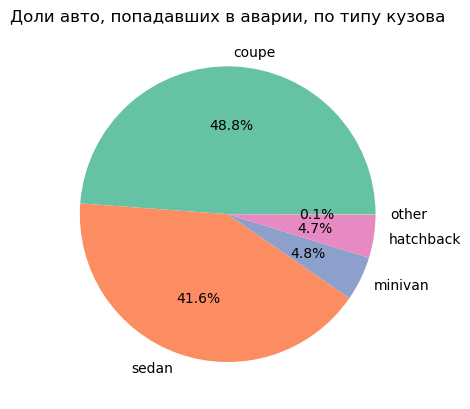

In [23]:
# построение круговой диаграммы
plt.pie(type_by_weather['count'],
        labels=type_by_weather['vehicle_type'],
        autopct='%1.1f%%',
        colors=sns.color_palette('Set2'))
plt.title('Доли авто, попадавших в аварии, по типу кузова')
plt.rcParams['figure.figsize'] = [7, 7]
plt.show()

**Вывод:**  
Чаще всего, по нашим данным, в аварии попадают **купе (48.8%) и седаны (41.6%)**. Следовательно, именно на авто с этими типами кузова следует сосредоточить внимание при каких-либо работах по уменьшению аварийности.

## Создайте модель для оценки водительского риска

### EDA

In [24]:
# отключение ограничения на кол-во отображаемых колонок в pandas
pd.options.display.max_columns = None

Я опишу, какие столбцы я убираю и почему, т.к. про остальные можно сказать только общую фразу "это полезная информация".  
**Parties:**
- `id`, `case_id`, `party_number` - ничего не значащие числа, не влияют на аварийность
- `party_type` - у нас он только один
- `insurance_premium` - размер выплаты по страховке на аварийность не влияет

**collisions**:  
- `case_id` - айди, не поможет в обучении
- `county_location`, `county_city_location` - населенные пункты. Их слишком много, скорее всего, будет усложнять обучение, при этом ничего не давая
- `direction` - направление движения не влияет на аварийность
- `distance, collision_damage, party_count, primary_collision_factor, pcf_violation_category, type_of_collision, motor_vehicle_involved_with` - это все характеристики уже совершившейся аварии, этих данных нет в тот момент, когда водитель садится за руль. А по условию задачи: 
> Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту

Соотв-но, эти факторы мы учитывать не можем

**Vehicles**:
- `id, case_id, party_number` - ничего не значащие числа, не влияют на аварийность

Данные столбцы я убрал в sql-запросе.  
Далее я рассмотрю каждый из оставшихся более подробно и обработаю.

In [25]:
# Выгрузка данных для обучения
data = sql('''
SELECT p.case_id,
       p.party_number,
       at_fault,
       party_sobriety,
       party_drug_physical,
       cellphone_in_use,
       intersection,
       weather_1,
       location_type,
       road_surface,
       road_condition_1,
       lighting,
       control_device,
       collision_date,
       collision_time,
       vehicle_type,
       vehicle_transmission,
       vehicle_age
FROM parties p
JOIN collisions c ON c.case_id = p.case_id
LEFT JOIN Vehicles v ON v.case_id = p.case_id
AND v.party_number = p.party_number
WHERE party_type = 'car'
  AND c.collision_damage <> 'scratch'
  AND extract('year'
              FROM collision_date) = 2012
''')
print(data.shape)
data.head()

(196837, 18)


,case_id,party_number,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age
0,5475551,5,0,had not been drinking,None,0.00,0.00,clear,highway,dry,normal,daylight,none,2012-01-07,11:05:00,sedan,manual,1.00
1,5621399,4,0,had not been drinking,None,1.00,0.00,cloudy,None,dry,normal,daylight,none,2012-03-31,17:49:00,sedan,auto,2.00
2,5481616,4,0,had not been drinking,None,0.00,0.00,clear,highway,dry,normal,daylight,none,2012-01-20,10:03:00,None,None,NaN
3,5483291,4,0,had not been drinking,None,0.00,0.00,clear,None,dry,normal,daylight,none,2012-01-17,07:50:00,None,None,NaN
4,5504525,4,0,impairment unknown,G,NaN,0.00,cloudy,highway,dry,normal,daylight,functioning,2012-02-13,12:56:00,None,None,NaN


Проверка таблицы на дубли по ключам, затем удаление

In [26]:
data[data.duplicated(subset=['case_id', 'party_number'])]

,case_id,party_number,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age


In [27]:
data.drop(columns=['case_id', 'party_number'], inplace=True)

In [28]:
# приведение категориальных колонок в подходящий для этого тип данных 
mask = data.select_dtypes('object').columns
data[mask] = data[mask].astype('category')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   at_fault              196837 non-null  int64   
 1   party_sobriety        193212 non-null  category
 2   party_drug_physical   25148 non-null   category
 3   cellphone_in_use      171464 non-null  float64 
 4   intersection          195850 non-null  float64 
 5   weather_1             196183 non-null  category
 6   location_type         87357 non-null   category
 7   road_surface          195564 non-null  category
 8   road_condition_1      195694 non-null  category
 9   lighting              196116 non-null  category
 10  control_device        195864 non-null  category
 11  collision_date        196837 non-null  category
 12  collision_time        195464 non-null  category
 13  vehicle_type          56248 non-null   category
 14  vehicle_transmission  55389 non-null

На данные я посмотрю с помощью профайлера

In [30]:
profile = ProfileReport(data, title="Profiling Report")

In [31]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Выводы на основании профайлинга данных:**
- at_fault: пропусков нет, баланс классов почти 50/50
- party_sobriety - есть пропущенные значения
- party_drug_physical - большинство значений пустые, из оставшихся - в основном, тоже категория, обозначающая отсутствие информации. И тем не менее, думаю, даже небольшое кол-во заполненных случаев даст нам прирост в качестве модели.
- cellphone_in_use - почти всё - это нули или нет данных. Вряд ли поможет в обучении, но посмотрим.
- intersection - всё ок, есть только небольшой процент пустых значений, заполню нулями
- weather_1 - всё ок, есть только небольшой процент пустых значений, заполню модой
- location_type - 55% данных отсутствует + частично дублирует столбец intersection. Думаю, пустые значения стоит заполнить отдельной категорией ("other") + intersection, если он дублируется, убрать. (судя по профайлу, корреляция у этих столбцов высокая).
- road_surface, road_condition_1, lighting, control_device - всё ок, есть только небольшой процент пустых значений, заполню модой
- collision_date, collision_time я разделю на категории (даты: месяц, день недели, время - подумаю, как)
- vehicle_type - 71% пропущенных значений, всего 2 варианта: седан /купе. Возможно, стоит удалить.
- vehicle_transmission - похожая история. Возможно, стоит удалить 
- vehicle_age - также много пропущенных значений, точно есть выбросы

Пропущенные значения я буду заполнять с помощью sklearn SimpleImputer

In [32]:
# в этом случае not applicable фактически равно G
data.loc[data.party_drug_physical == 'not applicable', 'party_drug_physical'] = 'G'
data['party_drug_physical'].fillna('G').value_counts(normalize=True)

party_drug_physical
G                        0.99
under drug influence     0.01
sleepy/fatigued          0.01
impairment - physical    0.00
not applicable           0.00
Name: proportion, dtype: float64

In [33]:
# проверка данных в колонках 'intersection', 'location_type'
data.pivot_table(index=['intersection', 'location_type'], values='at_fault', aggfunc='count')

at_fault
intersection location_type          
0.00         highway           71025
             intersection       1069
             ramp               9728
1.00         highway             838
             intersection       2835
             ramp               1772

Т.е. данные просто противорчат друг другу. Неизвестно, чему можно больше доверять.  
Также в описании данных не укзано, Location_type - это тип дороги, где случилось происшествие, или это весь путь водителя. Преположим, что это место происшествия.  
Есть более 1000 случаев, когда в location_type = intersection, а столбец intersection = 0. Я устраню это так: проставлю в столбце intersection единички там, где есть этот признак в location_type.  
В самом location_type тогда было бы логично убрать признак intersection и заменить на other, но для модели разницы не будет.

In [34]:
data.loc[data.location_type == 'intersection', 'intersection'] = 1
data['collision_date'] = pd.to_datetime(data['collision_date'])

Вместо даты и времени создадим категории:
- День недели
- Месяц
- Час

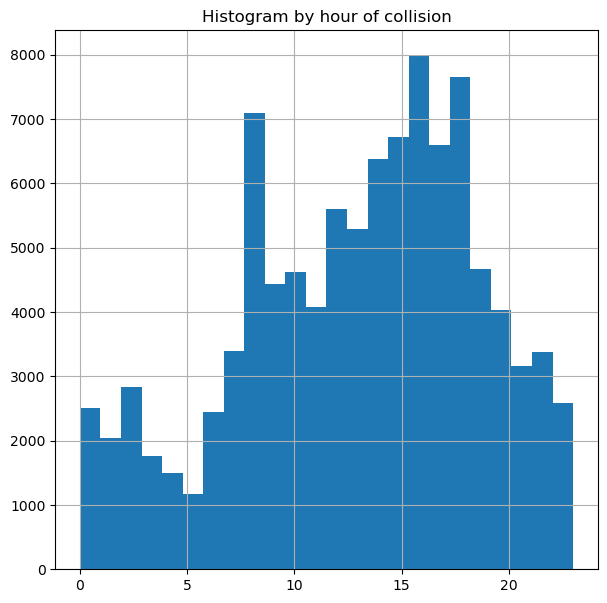

In [35]:
data['dayofweek'] = data['collision_date'].dt.dayofweek

data['month'] = data['collision_date'].dt.month

data['hour'] = pd.to_datetime(data['collision_time'], format='%H:%M:%S').dt.round('H').dt.hour

data.loc[data.at_fault == 1, 'hour'].hist(bins=24)
plt.title('Histogram by hour of collision')
plt.show()

In [36]:
# раскидаю по категориям время происшествия. 0 - всё остальное, т.е. ночь, 6-10 - это утро, далее день и т.д.
data['time_category'] = 0
data.loc[(data['hour'] >= 6) & (data['hour'] <= 10), 'time_category'] = 1
data.loc[(data['hour'] >= 11) & (data['hour'] <= 14), 'time_category'] = 2
data.loc[(data['hour'] >= 15) & (data['hour'] <= 18), 'time_category'] = 3
data.loc[(data['hour'] >= 19) & (data['hour'] <= 21), 'time_category'] = 4

# Колонки больше не нужны
data.drop(columns=['hour', 'collision_date', 'collision_time'], inplace=True)

Рассмотрим `vehicle_age`

In [37]:
data['vehicle_age'].fillna(-1).value_counts(normalize=True)

vehicle_age
-1.00      0.72
 3.00      0.06
 4.00      0.04
 2.00      0.03
 5.00      0.03
 6.00      0.02
 7.00      0.02
 8.00      0.02
 0.00      0.02
 9.00      0.01
 1.00      0.01
 10.00     0.01
 11.00     0.01
 12.00     0.00
 13.00     0.00
 14.00     0.00
 15.00     0.00
 16.00     0.00
 17.00     0.00
 161.00    0.00
 19.00     0.00
Name: proportion, dtype: float64

Тут определенно есть выброс - значение 161. Очищу его (в дальнейшнем, при обучении, пропуски будут заполняться)

In [38]:
data.loc[data.vehicle_age == 161, 'vehicle_age'] = None

В дальнейшем пригодится список категориальных колонок

In [39]:
cat_cols = data.columns.tolist()
cat_cols.remove('vehicle_age')
cat_cols.remove('at_fault')
cat_cols

['party_sobriety',
 'party_drug_physical',
 'cellphone_in_use',
 'intersection',
 'weather_1',
 'location_type',
 'road_surface',
 'road_condition_1',
 'lighting',
 'control_device',
 'vehicle_type',
 'vehicle_transmission',
 'dayofweek',
 'month',
 'time_category']

In [40]:
data[cat_cols] = data[cat_cols].astype('category')

Финальная информация о датасете

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   at_fault              196837 non-null  int64   
 1   party_sobriety        193212 non-null  category
 2   party_drug_physical   25148 non-null   category
 3   cellphone_in_use      171464 non-null  category
 4   intersection          195863 non-null  category
 5   weather_1             196183 non-null  category
 6   location_type         87357 non-null   category
 7   road_surface          195564 non-null  category
 8   road_condition_1      195694 non-null  category
 9   lighting              196116 non-null  category
 10  control_device        195864 non-null  category
 11  vehicle_type          56248 non-null   category
 12  vehicle_transmission  55389 non-null   category
 13  vehicle_age           54552 non-null   float64 
 14  dayofweek             196837 non-nul

**Вывод по итогам обработки данных:**  
- Выбраны нужные колонки, объяснен выбор
- Все данные подробно рассмотрены с помощью профайлинга
- Исправлены ошибки в столбце `intersection`
- Созданы новые категориальные колонки на основе даты и времени
- Найден 1 выброс в столбце `vehicle_age` и очищен
- Оптимизированы типы данных

### Разделение на трейн и тест выборки

In [42]:
SEED = 777
# выделяем тестовые данные (20%), на которых будет проверяться итоговая модель
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns='at_fault'),
                                                    data['at_fault'],
                                                    test_size=0.2, random_state=SEED)
print(X_train.shape)
print(X_test.shape)

(157469, 16)
(39368, 16)


Данные готовы к машинному обучению

### Выбор метрики качества

Исходя из бизнес-задачи выходит, что нужно учитывать и полноту, и точность предсказаний, т.к. мы хотим охватить как можно больше случаев аварий, при этом, не сильно жертвуя точностью, потому что это не понравится клиентам и грозит репутационными издержками.  
Сл-но, наш выбор - это **ROC-AUC score**.   


Забегая вперед, делая задачу, я выяснил, что если модель выдает только единичные значения, то метрика F1 принимает значение 0.69. А вот ROC-AUC лишена данного недостатка.  
Пример:

In [43]:
f1_score(Y_test, np.ones(len(Y_test)))

0.6852572344582296

In [44]:
roc_auc_score(Y_test, np.ones(len(Y_test)))

0.5

Минимальное значение roc-auc -- 0.5, поэтому, очевидно, такая модель считаться хорошей не будет.

### RandomForestClassifier

**Базовая модель без перебора параметров**

In [45]:
def do_pipeline(model):
    '''
    создает обыкновенный пайплайн с порядковым кодированием текстовых фичей и заполнением пропусков
    '''
    # pipeline для категориальных переменных - заполняем самым частым значением, затем кодируем с OrdinalEncoder
    cat_pipeline = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    
    # объединяем cat_pipeline и SimpleImputer по медиане для числовых колонок
    preprocessing = ColumnTransformer([
            ("cat", cat_pipeline, cat_cols),
            ("num", SimpleImputer(strategy="median"), ['vehicle_age'])])
    
    # финальный пайплайн - добавляем модель
    pipeline = Pipeline([("preprocessing", preprocessing),
#                          ("scaler", StandardScaler()),
                         ('model', model)])
    return pipeline

In [46]:
rf_pipe = do_pipeline(RandomForestClassifier(random_state=SEED))

In [47]:
rf_pipe.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['party_sobriety',
                                                   'party_drug_physical',
                                                   'cellphone_in_use',
                                                   'intersection', 'weather_1',
                                                   'location_type',
                                                   'road_surface',
                                                   'road_condition_1',
                                                   'lighting', 'control_device',
                                                   'vehicle_type',
                                                   'vehicle_transmission',
                                                   'dayofweek', 'month',
                                                   'time_category']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['vehicle_age'])])),
                ('model', RandomForestClassifier(random_state=777))])

In [48]:
pred = rf_pipe.predict(X_test)

roc_auc_score(Y_test, pred)

0.5913913293758724

In [102]:
%%time

param_grid = {'model__n_estimators': Integer(50, 500),
              'model__criterion': Categorical(['gini', 'entropy', 'log_loss']),
              'model__max_depth': Integer(2, 25),
              'model__min_samples_split': Integer(2, 25),
              'model__min_samples_leaf': Integer(1, 25),
              'model__max_features': Real(0.1, 1.0, prior='uniform')
               }

rf_cv = BayesSearchCV(estimator = rf_pipe, 
                  search_spaces = param_grid, 
                  cv = 3,
                  n_jobs=-1, 
                  verbose = 1,
                  n_iter=30,
                  scoring='roc_auc')

rf_cv.fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessing',
                                         ColumnTransformer(transformers=[('cat',
                                                                          Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('ordinalencoder',
                                                                                           OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                          unknown_value=-1))]),
                                                                          ['party_sobriety',
                                                                           'party_drug_physical',
                                                                           'cellphone_in_use',
                                                                           'intersection',
                                                                           'weather_1',...
                             'model__max_features': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'model__min_samples_leaf': Integer(low=1, high=25, prior='uniform', transform='normalize'),
                             'model__min_samples_split': Integer(low=2, high=25, prior='uniform', transform='normalize'),
                             'model__n_estimators': Integer(low=50, high=500, prior='uniform', transform='normalize')},
              verbose=1)

In [156]:
print(rf_cv.best_params_)
print(rf_cv.best_score_)

OrderedDict([('model__criterion', 'entropy'), ('model__max_depth', 11), ('model__max_features', 0.6822064353574587), ('model__min_samples_leaf', 15), ('model__min_samples_split', 14), ('model__n_estimators', 132)])
0.6767722645068215


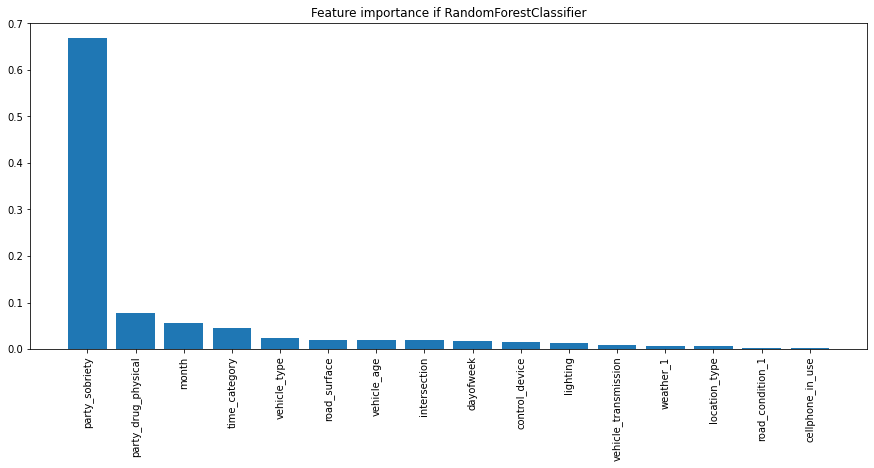

In [186]:
rf_feat_imp = pd.DataFrame({'importance': rf_cv.best_estimator_[-1].feature_importances_,
               'feature': X_train.columns}).sort_values('importance', ascending=False)

plt.figure(figsize=(15,6))
plt.bar('feature', 'importance', data=rf_feat_imp)
plt.xticks(rotation=90)
plt.title('Feature importance if RandomForestClassifier')
plt.show()

In [106]:
rf_feat_imp.head()

,importance,feature
0,0.67,party_sobriety
1,0.08,party_drug_physical
14,0.06,month
15,0.05,time_category
10,0.02,vehicle_type


По мнению RandomForestClassifier, самыми важными параметрами являются:
- party_sobriety - **Трезвость водителя** - 67%
- party_drug_physical - **Состояние участника: физическое или с учётом принятых лекарств** 8%
- month - **месяц** - 6%
- time_category - **категория времени дня** - 5%
- vehicle_type - **тип авто** - 2%


**AUC-ROC score** у RandomForestClassifier: 0.677

### LightGBM

In [107]:
def do_pipeline(model):
    '''
    создает обыкновенный пайплайн с порядковым кодированием текстовых фичей и заполнением пропусков
    '''
    # pipeline для категориальных переменных - заполняем самым частым значением, затем кодируем с OneHotEncoder
    cat_pipeline = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore"))
    
    # объединяем cat_pipeline и SimpleImputer по медиане для числовых колонок
    preprocessing = ColumnTransformer([
            ("cat", cat_pipeline, cat_cols),
            ("num", SimpleImputer(strategy="median"), ['vehicle_age'])])
    
    # финальный пайплайн - добавляем модель
    pipeline = Pipeline([("preprocessing", preprocessing),
                         ("scale", StandardScaler(with_mean=False)),
                         ('model', model)])
    return pipeline

In [108]:
lgbm_pipe = do_pipeline(lgb.LGBMClassifier(random_state=SEED))

In [109]:
lgbm_pipe.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['party_sobriety',
                                                   'party_drug_physical',
                                                   'cellphone_in_use',
                                                   'intersection', 'weather_1',
                                                   'location_type',
                                                   'road_surface',
                                                   'road_condition_1',
                                                   'lighting', 'control_device',
                                                   'vehicle_type',
                                                   'vehicle_transmission',
                                                   'dayofweek', 'month',
                                                   'time_category']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['vehicle_age'])])),
                ('scale', StandardScaler(with_mean=False)),
                ('model', LGBMClassifier(random_state=777))])

In [110]:
pred = lgbm_pipe.predict(X_test)

roc_auc_score(Y_test, pred)

0.6354620581767785

In [113]:
%%time

param_grid = {'model__boosting_type': Categorical(['gbdt', 'dart']),
              'model__num_leaves': Integer(10, 40),
              'model__max_depth': Integer(1, 25),
              'model__n_estimators': Integer(50, 500),
              'model__subsample': Real(0.1, 1.0, prior='uniform'),
              'model__reg_lambda': Real(1e-4, 1e-1, prior='log-uniform'),
              'model__min_split_gain': Real(0.1, 1.0, prior='uniform')
               }

lgbm_cv = BayesSearchCV(estimator = lgbm_pipe, 
                  search_spaces = param_grid, 
                  cv = 3,
                  n_jobs=-1, 
                  verbose = 1,
                  n_iter=30,
                  scoring='roc_auc',
                  random_state=SEED)

lgbm_cv.fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessing',
                                         ColumnTransformer(transformers=[('cat',
                                                                          Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('onehotencoder',
                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                          ['party_sobriety',
                                                                           'party_drug_physical',
                                                                           'cellphone_in_use',
                                                                           'intersection',
                                                                           'weather_1',
                                                                           'location_type',
                                                                           'road_surface'...
                             'model__min_split_gain': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'model__n_estimators': Integer(low=50, high=500, prior='uniform', transform='normalize'),
                             'model__num_leaves': Integer(low=10, high=40, prior='uniform', transform='normalize'),
                             'model__reg_lambda': Real(low=0.0001, high=0.1, prior='log-uniform', transform='normalize'),
                             'model__subsample': Real(low=0.1, high=1.0, prior='uniform', transform='normalize')},
              verbose=1)

In [142]:
print('Best params:\n', lgbm_cv.best_params_)
print('Best score:\n', lgbm_cv.best_score_)

Best params:
 OrderedDict([('model__boosting_type', 'dart'), ('model__max_depth', 12), ('model__min_split_gain', 0.13236975134859677), ('model__n_estimators', 304), ('model__num_leaves', 17), ('model__reg_lambda', 0.00017161423767550948), ('model__subsample', 0.52194561147511)])
Best score:
 0.6778394989006896


,importance,feature
74,890,num__vehicle_age
12,366,cat__intersection_0.0
3,304,cat__party_sobriety_had not been drinking
2,269,"cat__party_sobriety_had been drinking, under i..."
5,247,cat__party_sobriety_not applicable


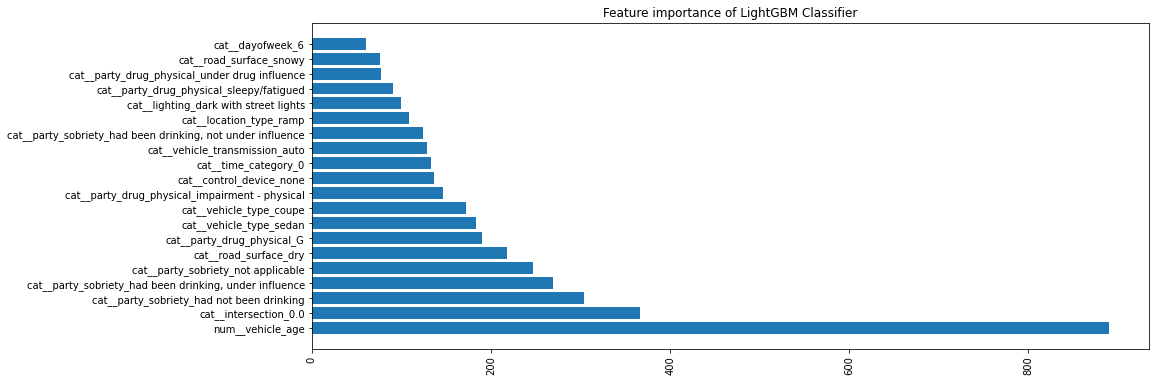

In [192]:
lgb_feat_imp = pd.DataFrame({'importance': lgbm_cv.best_estimator_[-1].feature_importances_, \
           'feature': lgbm_cv.best_estimator_[0].get_feature_names_out()}) \
           .sort_values('importance', ascending=False)
plt.figure(figsize=(15,6))
plt.barh('feature', 'importance', data=lgb_feat_imp[:20])
plt.xticks(rotation=90)
plt.title('Feature importance of LightGBM Classifier')
display(lgb_feat_imp.head())
plt.show()

**Вывод**  
Скоринг roc-auc составил 0.677  
Самые важные параметры:
- Возраст авто
- Отсутствие перекрестка
- Алгокольное состояние (разные виды)
- Состояние дороги
- Тип автомобиля

### RidgeClassifier

In [27]:
def do_pipeline(model):
    '''
    создает обыкновенный пайплайн с порядковым кодированием текстовых фичей и заполнением пропусков
    '''
    # pipeline для категориальных переменных - заполняем самым частым значением, затем кодируем с OneHotEncoder
    cat_pipeline = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore"))
    
    # объединяем cat_pipeline и SimpleImputer по медиане для числовых колонок
    preprocessing = ColumnTransformer([
            ("cat", cat_pipeline, cat_cols),
            ("num", SimpleImputer(strategy="median"), ['vehicle_age'])])
    
    # финальный пайплайн - добавляем модель
    pipeline = Pipeline([("preprocessing", preprocessing),
                         ("scale", StandardScaler(with_mean=False)),
                         ('model', model)])
    return pipeline

In [28]:
r_pipe = do_pipeline(RidgeClassifier(random_state=SEED))
r_pipe.fit(X_train, Y_train)
pred = r_pipe.predict(X_test)
roc_auc_score(Y_test, pred)

0.6332535714996181

In [29]:
%%time

param_grid = {'model__alpha': Integer(10, 10000)}

r_cv = BayesSearchCV(estimator = r_pipe, 
                  search_spaces = param_grid, 
                  cv = 3,
                  n_jobs=-1, 
                  verbose = 1,
                  n_iter=30,
                  scoring='roc_auc',
                  random_state=SEED)

r_cv.fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessing',
                                         ColumnTransformer(transformers=[('cat',
                                                                          Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('onehotencoder',
                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                          ['party_sobriety',
                                                                           'party_drug_physical',
                                                                           'cellphone_in_use',
                                                                           'intersection',
                                                                           'weather_1',
                                                                           'location_type',
                                                                           'road_surface'...
                                                                           'vehicle_transmission',
                                                                           'dayofweek',
                                                                           'month',
                                                                           'time_category']),
                                                                         ('num',
                                                                          SimpleImputer(strategy='median'),
                                                                          ['vehicle_age'])])),
                                        ('scale',
                                         StandardScaler(with_mean=False)),
                                        ('model',
                                         RidgeClassifier(random_state=777))]),
              n_iter=30, n_jobs=-1, random_state=777, scoring='roc_auc',
              search_spaces={'model__alpha': Integer(low=10, high=10000, prior='uniform', transform='normalize')},
              verbose=1)

In [30]:
print(r_cv.best_params_)
print(r_cv.best_score_)

OrderedDict([('model__alpha', 1373)])
0.6668050391137793


После того, как я обучил модель RidgeClassifier, я могу получить коэффициенты (веса) каждой фичи, используя атрибут `coef_`. Чем больше по абсолютной величине коэффициент, тем важнее соответствующая фича.

,importance_coef,feature
3,0.16,cat__party_sobriety_had not been drinking
6,0.04,cat__party_drug_physical_G
74,0.04,num__vehicle_age
47,0.03,cat__vehicle_type_sedan
5,0.03,cat__party_sobriety_not applicable


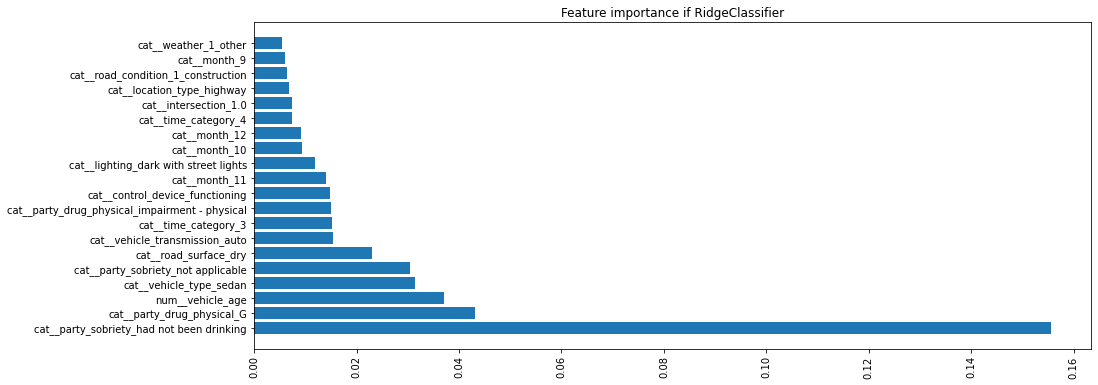

In [31]:
ri_feat_imp = pd.DataFrame({'importance_coef': r_cv.best_estimator_[-1].coef_[0], \
           'feature': r_cv.best_estimator_[0].get_feature_names_out()}) \
           .sort_values('importance_coef')
# коэффициенты бывают отрицательными. Нам нужно получить абсолютное значение
ri_feat_imp['importance_coef'] = ri_feat_imp['importance_coef'].abs()

plt.figure(figsize=(15,6))
plt.barh('feature', 'importance_coef', data=ri_feat_imp[:20])
plt.xticks(rotation=90)
display(ri_feat_imp.head())
plt.title('Feature importance if RidgeClassifier')
plt.show()

**Вывод**  
Самые важные параметры, влияющие на вероятность аварии:
- Состояние опьянения или его отсутствие
- Влияние препаратов
- Возраст автомобиля
- Тип автомобиля
- Состояние дороги

И т.д.

**AUC-ROC составил 0.667**

### Catboost

Подготовка данных для обучения

In [191]:
# Создание объекта SimpleImputer с заполнением самым частым значением
imputer_cat = SimpleImputer(strategy='most_frequent')
# преобразование фичей для трейн и тест выборок
X_train_catboost = pd.DataFrame(imputer_cat.fit_transform(X_train[cat_cols].values), columns=cat_cols)
X_test_catboost = pd.DataFrame(imputer_cat.transform(X_test[cat_cols].values), columns=cat_cols)


# Создание объекта SimpleImputer с заполнением медианой
imputer_num = SimpleImputer(strategy='median')
# преобразование фичей для трейн и тест выборок
X_train_catboost['vehicle_age'] = \
pd.Series(imputer_num.fit_transform(X_train['vehicle_age'].values.reshape(-1, 1)).ravel())
X_test_catboost['vehicle_age'] = \
pd.Series(imputer_num.transform(X_test['vehicle_age'].values.reshape(-1, 1)).ravel())

In [27]:
# проверим, что все заполнилось
X_train_catboost.isna().sum()

party_sobriety          0
party_drug_physical     0
cellphone_in_use        0
intersection            0
weather_1               0
location_type           0
road_surface            0
road_condition_1        0
lighting                0
control_device          0
vehicle_type            0
vehicle_transmission    0
dayofweek               0
month                   0
time_category           0
vehicle_age             0
dtype: int64

In [28]:
# также придется вручную перевести некоторые колонки, ставшие float, в int,
# чтобы catboost принял их как категориальные
X_train_catboost[['cellphone_in_use', 'intersection']] = \
X_train_catboost[['cellphone_in_use', 'intersection']].astype('int')

X_test_catboost[['cellphone_in_use', 'intersection']] = \
X_test_catboost[['cellphone_in_use', 'intersection']].astype('int')

In [29]:
# Создание объекта Pool для обучения
train_pool = Pool(X_train_catboost, label=Y_train, cat_features=cat_cols)

Первая модель - без подбора гиперпараметров

In [147]:
cat_model = CatBoostClassifier(iterations=300, depth=5, learning_rate=0.1, loss_function='Logloss', eval_metric='AUC')
cat_model.fit(train_pool, plot=True, logging_level='Silent')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [149]:
pred = cat_model.predict(X_test_catboost)
roc_auc_score(Y_test, pred)

0.636102419931198

**Подбор гиперпараметров**

In [150]:
# Определение параметров для поиска по сетке
grid = {
    'depth': [3, 5, 10, 15],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Создание и обучение модели с поиском по сетке
cat_model = CatBoostClassifier(loss_function='Logloss',
                               iterations=300,
                               cat_features=cat_cols,
                               eval_metric='AUC',
                               logging_level='Silent')
grid_search_result = cat_model.grid_search(grid, train_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.6729062	best: 0.6729062 (0)	total: 44.5s	remaining: 11m 8s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.6729705	best: 0.6729705 (1)	total: 1m 29s	remaining: 10m 25s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.6728904	best: 0.6729705 (1)	total: 2m 13s	remaining: 9m 39s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.6733804	best: 0.6733804 (3)	total: 2m 58s	remaining: 8m 55s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
4:	loss: 0.6740728	best: 0.6740728 (4)	total: 

In [152]:
# Вывод лучших гиперпараметров
print("Лучшие гиперпараметры:", grid_search_result['params'])

Лучшие гиперпараметры: {'depth': 10, 'l2_leaf_reg': 7}


Выведу важность фич. В данном случае `PredictionValuesChange` показывает, на сколько в средем меняется предсказание при изменении значения фичи. Больше значение - фича важнее.

,importance,feature
0,47.2996,party_sobriety
1,11.7154,party_drug_physical
15,6.5599,vehicle_age
10,6.3523,vehicle_type
14,4.2681,time_category


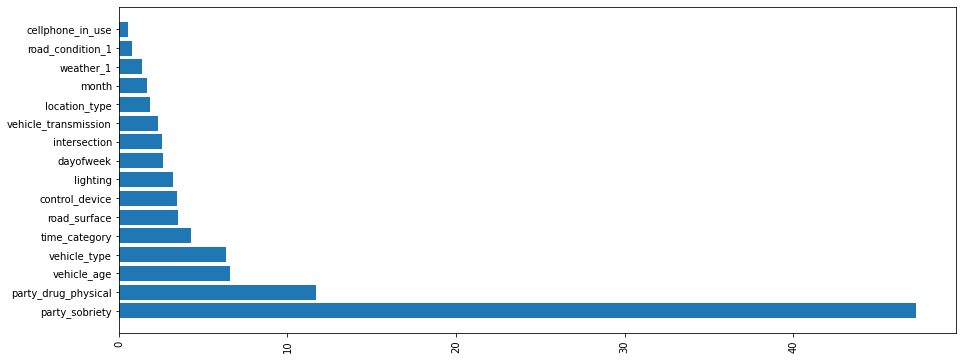

In [201]:
ctb_feat_imp = pd.DataFrame({'importance': cat_model.get_feature_importance(type='PredictionValuesChange'), \
           'feature': X_test_catboost.columns}) \
           .sort_values('importance', ascending=False)
ctb_feat_imp['importance'] = ctb_feat_imp['importance'].abs()

plt.figure(figsize=(15,6))
plt.barh('feature', 'importance', data=ctb_feat_imp[:20])
display(ctb_feat_imp.head())
plt.show()

**Вывод**  
Самые важные параметры:
- Трезвость водителя
- Состояние участника: физическое или с учётом принятых лекарств
- Возраст автомобиля
- Тип автомобиля

Лучший AUC-ROC score у Catboost равен 0.675.

### Выбор лучшей модели

Таблица со сравнением скоринга моделей на тестовой выборке

In [167]:
pd.options.display.float_format = '{:,.4f}'.format

In [216]:
pd.DataFrame([
    ['RandomForest', 0.6767722645068215],
    ['LightGBM', 0.6778394989006896],
    ['Ridge', 0.6668050391137793],
    ['Catboost', 0.675]
], columns=['model', 'test_score']).sort_values('test_score', ascending=False)

,model,test_score
1,LightGBM,0.6778
0,RandomForest,0.6768
3,Catboost,0.6750
2,Ridge,0.6668


Результаты практически одинаковые.

С минимальным отрывом лидером становится **LightGBM** по скорингу.

### Тестирование лучшей модели

In [173]:
def do_pipeline(model):
    '''
    создает обыкновенный пайплайн с порядковым кодированием текстовых фичей и заполнением пропусков
    '''
    # pipeline для категориальных переменных - заполняем самым частым значением, затем кодируем с OneHotEncoder
    cat_pipeline = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore"))
    
    # объединяем cat_pipeline и SimpleImputer по медиане для числовых колонок
    preprocessing = ColumnTransformer([
            ("cat", cat_pipeline, cat_cols),
            ("num", SimpleImputer(strategy="median"), ['vehicle_age'])])
    
    # финальный пайплайн - добавляем модель
    pipeline = Pipeline([("preprocessing", preprocessing),
                         ("scale", StandardScaler(with_mean=False)),
                         ('model', model)])
    return pipeline


best_lgb_param = [('boosting_type', 'dart'),
                  ('max_depth', 12),
                  ('min_split_gain', 0.13236975134859677),
                  ('n_estimators', 304),
                  ('num_leaves', 17),
                  ('reg_lambda', 0.00017161423767550948),
                  ('subsample', 0.52194561147511)]

lgbm_pipe = do_pipeline(lgb.LGBMClassifier(**dict(best_lgb_param), random_state=SEED))
lgbm_pipe.fit(X_train, Y_train)

print('ROC-AUC on test data with best model:', roc_auc_score(Y_test, lgbm_pipe.predict(X_test)))

In [233]:
def plot_confusion_matrix(Y_test, pred, title):
    'Визуализация матрицы ошибок'
    cm = confusion_matrix(Y_test, pred)
    plt.rcParams['figure.figsize'] = [5, 4]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f'Confusion matrix of {title} model')
    plt.show()

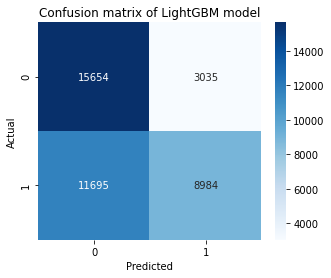

In [232]:
plot_confusion_matrix(Y_test, lgbm_pipe.predict(X_test), 'LightGBM')

**Вывод**  
Скоринг лучшей модели (LightGBM) составил 0.63 на тестовой выборке.

## Проведите анализ важности факторов ДТП

Наши модели в целом показали очень близкий скоринг, будет более объективным рассматривать значение их фич в совокупности.  
Самым (или одним из) важным фактором является **уровень трезвости участника**, он присутствовал в топ-5 во всех моделях, 3 раза из четырех - на 1 месте.  
Исследуем уровень аварийности в зависимости от значения параметра.  

In [48]:
drink = data.pivot_table(index='party_sobriety', values='at_fault', aggfunc='mean') \
    .sort_values(by='at_fault')

In [49]:
drink

,at_fault
party_sobriety,
had not been drinking,0.45
not applicable,0.48
"had been drinking, not under influence",0.72
impairment unknown,0.83
"had been drinking, impairment unknown",0.84
"had been drinking, under influence",0.96


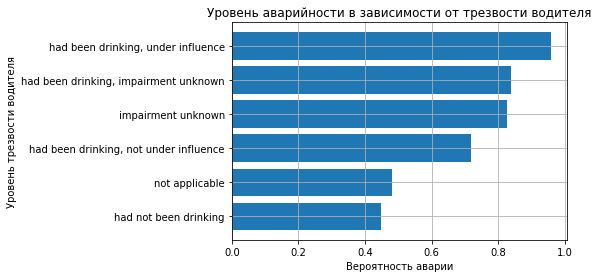

In [54]:
plt.barh(drink.index, drink['at_fault'])
plt.xlabel('Вероятность аварии')
plt.ylabel('Уровень трезвости водителя')
plt.title('Уровень аварийности в зависимости от трезвости водителя')
plt.grid()
plt.show()

Уровни трезвости и аварийность логично расположись в порядке "убывания" трезвости (или наличия информации о ней).

### Рекомендации для бизнеса
#### 1
Взять 3% автомобилей, **оборудовать алкотестером** (ипользование алкотестера сделать обязательным), провести анализ статистической значимости:  

**Нулевая гипотеза:** установка алкотестеров не повлияет на прибыль компании.  
Чтобы опровергнуть эту гипотезу, потребуется посчитать расходы на установку и обслуживание алкотестеров и прибыль от снижения кол-ва аварий. На основании данных тестовой группы посчитать p-уровень значимости и сделать вывод.  
Также стоит обратить внимание на реакцию СМИ: если благодаря нововведению ухудшится имидж компании (= будет меньше поездок, и это перекроет прибыль от уменьшения аварийности), то нововведение стоит отменить.
#### 2
На основании данных можно составить хорошую систему предсказания аварийности, однако, для того, чтобы **более точно предсказывать аварийность, очень сильно не хватает данных о**:
1. Загруженности дорог, дорожном трафике, по поездкам
2. Состоянии автомобиля (например, как давно обслуживались те или иные системы)
3. Истории поездок клиента: нарушает ли скоростной режим, агрессивно ли водит и пр.
4. Данные содержат пропуски - их нужно устранить.

Необходимо поставить задачу отделу инженеров данных на привоз необходимых данных. Со стороны DS разработать новую модель с учетом новых вводных и посмотреть, улучшится ли качество предсказаний.

### Оценка адекватности модели

Модель в текущем состоянии я **не рекомендую использовать** в проде.  

Если взглянуть на матрицы ошибок выше, видно, что каждая из четырех моделей делает много `False-Negative` прогнозов, т.е. не определяет вероятность аварии там, где она реально была. Я связываю это с недостатком данных, подробнее описал выше.  

Однако работа не была проделана зря: уже на этих данных удалось сформировать гипотезу и понять, каких данных не хватает для улучшения прогнозирования.

## Выводы

Были проделаны следующие шаги:
1. Изучена структура данных в БД
2. Поставлены задачи на статистическое исследование данных коллегам. Две задачи решены и визуализированы. Поставлены гипотезы о точках роста бизнеса.
3. Выбраны нужные данные на построения модели, позволяющей предсказывать ДТП, обоснован выбор
4. Данные подробно рассмотрены на наличие пропусков, выбросов, некорректных категориальных значений
5. Данные исправлены, подготовлены к обучению моделей
6. Построены 4 классификационных модели: RandomForest, LightGBM, Ridge, Catboost. Все они показали скоринг AUC-ROC на трейне (при кросс-валидации) ~0.67.
7. По каждой модели графически отображены наиболее важные фичи
8. Выбрана лучшая модель - LightGBM - её скоринг оказался самым высоким, однако отрыв минимален. Построена марица ошибок.
9. Самые важные критерии для LightGBM:
    - Возраст авто
    - Отсутствие перекрестка
    - Алгокольное состояние (разные виды)
    - Состояние дороги
    - Тип автомобиля
10. Самой важной фичей в совокупности всех моделей выбрана "уровень трезвости". Проведен графический анализ вероятности аварии в зависимости от трезвости. Согласно нему, действительно, уровень опьянения сильно влияет на аварийность.
11. Даны рекомендации бизнесу:
    - Провести АБ-тестирование по установке алкотестеров в авто
    - Собирать больше данных о поездке, авто и водителе
12. Не рекомендуется использовать модель в боевых задачах по причине высокой доли ложноотрицательных прогнозов и наличию большого потенциала к улучшению.